In [3]:
import os
import zipfile
import requests
import glob
import sys
import re

import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions 
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.mixed_precision import set_global_policy


%matplotlib inline

2024-12-27 22:52:44.499100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735357964.598597   82264 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735357964.628377   82264 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 22:52:44.874053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Getting python version
print(sys.version)

3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]


In [5]:
#Getting tensorflow version
tf.__version__

'2.18.0'

In [6]:
#Checking that Tensorflow detects a GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
if gpus:
    try:
        # Restrict TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [8]:
# Check if the TF_GPU_ALLOCATOR environment variable is set
gpu_allocator = os.environ.get('TF_GPU_ALLOCATOR')

if gpu_allocator is None:
    print("Warning: The TF_GPU_ALLOCATOR environment variable is not set. This variable determines how TensorFlow manages GPU memory allocation."
          "Setting it to 'cuda_malloc_async' can improve performance on NVIDIA GPUs by reducing memory fragmentation during model training. "
          " Please consider setting the variable before running the model.")
else:
    print(f"TF_GPU_ALLOCATOR is set to: {gpu_allocator}")

TF_GPU_ALLOCATOR is set to: cuda_malloc_async


In [9]:
#set mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [10]:
#setting seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [11]:
#hide some warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Download images to train our model

In [12]:
DATASET_DIR = '../dataset/fashion-product-images-small/myntradataset/'
ZIP_FILE_PATH = os.path.join(DATASET_DIR, 'fashion-product-images-small.zip')
DOWNLOAD_URL = 'https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small'

In [13]:
def is_empty_directory(directory):
    return not os.listdir(directory)

In [14]:
if is_empty_directory(DATASET_DIR):
    print("Empty dataset directory. Downloading ZIP File from Kaggle...")
    
    response = requests.get(DOWNLOAD_URL, allow_redirects=True)
    with open(ZIP_FILE_PATH, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Extract the ZIP file
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    print("ZIP file extracted.")

    # Delete the ZIP file after extraction
    os.remove(ZIP_FILE_PATH)
else:
    print("The are images already downloaded. No need to download Zip file from Kaggle")

The are images already downloaded. No need to download Zip file from Kaggle


# EDA

In [15]:
#Load an image
image_path = f'{DATASET_DIR}/images/'
fullname = f'{image_path}/10009.jpg'
img=load_img(fullname, target_size=(224,224))

In [16]:
x=np.array(img)
x.shape

(224, 224, 3)

In [17]:
## Reading informacion about images
CSV_FILE_PATH = F'{DATASET_DIR}/styles.csv'

In [18]:
# Read the first few rows of the CSV to inspect its structure
preview_data = pd.read_csv(CSV_FILE_PATH, nrows=5)
print(preview_data.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2012  Casual             Peter England Men Party Blue Jeans  
2  2016  Casual                       Titan Women Silver Watch  
3  2011  Casual  Manchester United Men Solid Black Track Pants  
4  2012  Casual                          Puma Men Grey T-shirt  


In [19]:
#read dataset and skip some bad lines
columns=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'productDisplayName']
data = pd.read_csv(CSV_FILE_PATH,  usecols=columns, on_bad_lines='skip')
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt


In [20]:
type(data)

pandas.core.frame.DataFrame

In [21]:
#Adding a new column to dataset, with the file name
data['filename'] = data['id'].astype(str)+'.jpg'
data['filename'] = data['filename'].str.strip() 
data['filename'] = data['filename'].str.lower()  
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt,53759.jpg


In [22]:
IMAGES_DIR = f'{DATASET_DIR}/images'

In [23]:
# Checking for invalid filenames and getting information about images
invalid_filenames = []
image_sizes = []
all_images = []
for filename in data['filename']:
    file_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(file_path):
        invalid_filenames.append(filename)
    else:
        img = Image.open(file_path)
        image_sizes.append(img.size)
print("Invalid filenames:\n")
for invalid in invalid_filenames:
    print(invalid)


Invalid filenames:

39403.jpg
39410.jpg
39401.jpg
39425.jpg
12347.jpg


In [24]:
# Checking for images which information might not be on the dataset 
all_images = set(os.listdir(IMAGES_DIR))
dataset_filenames = set(data['filename'])
orphaned_images = all_images-dataset_filenames
if orphaned_images:
    print("\nOrphaned images (not in the dataset):\n")
    for img in orphaned_images:
        print(img)
else:
    print("\nAll images in the directory have corresponding entries in the dataset.")


All images in the directory have corresponding entries in the dataset.


In [25]:
#There are some missing images, we will just erase their information from the dataset
data_cleaned = data[~data['filename'].isin(invalid_filenames)]
print(f'Total images that will be used as input: {len(data_cleaned)}')

Total images that will be used as input: 44441


Displaying image corresponding to the article 'Turtle Check Men Navy Blue Shirt' of type 'Shirts'


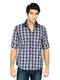

In [26]:
#Load one of the images to check is dimensions
sample_image_filename = data.iloc[0].filename
sample_image_fullname = f'{IMAGES_DIR}/{sample_image_filename}'
sample_image_displayName =  data.iloc[0].productDisplayName
sample_image_articleType = data.iloc[0].articleType
img = load_img(sample_image_fullname)

print(f'Displaying image corresponding to the article \'{sample_image_displayName}\' of type \'{sample_image_articleType}\'')
img

In [27]:
x=np.array(img)
x.shape

(80, 60, 3)

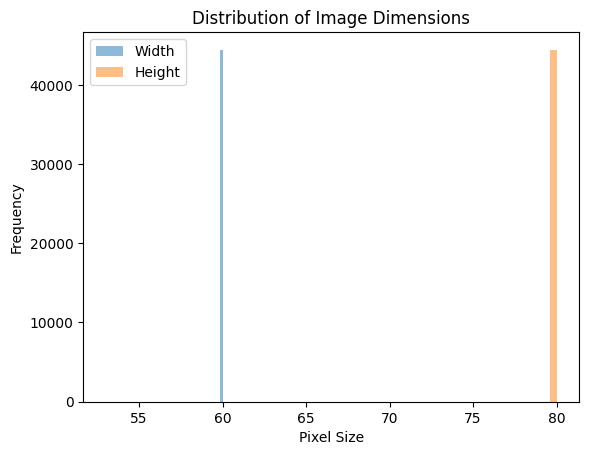

In [28]:
#Analyzing distribution of image dimensions
width, height = zip(*image_sizes)
plt.hist(width, bins=50, alpha=0.5, label='Width')
plt.hist(height, bins=50, alpha=0.5, label='Height')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

In [29]:
# Conclusion: All the images have a size of 60x80

In [30]:
# defining a target size for images
TARGET_SIZE = (96, 96)
#defining a batch size
BATCH_SIZE=32
#defining a max queue size (count of batches preloaded in the queue while the model is training)
MAX_QUEUE_SIZE=10

In [31]:
# calculating how many workers threads for loading data
##warning: it is not certain that these parameters are being used by the ImageDataGenerator
num_cores = os.cpu_count()
workers = int(num_cores / 2)
use_multiprocessing=False
if workers>1:
   use_multiprocessing=True

In [32]:
#Read images by using ImageDataGenerator (we will use the articleType as our class)
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [33]:
train_gen = image_gen.flow_from_dataframe(
    dataframe=data_cleaned,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    subset='training',
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 35553 validated image filenames belonging to 142 classes.


In [34]:
val_gen = image_gen.flow_from_dataframe(
    dataframe=data_cleaned,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    subset='validation',
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8888 validated image filenames belonging to 142 classes.


In [35]:
#Classes for the images
class_indices= train_gen.class_indices
class_indices

{'Accessory Gift Set': 0,
 'Baby Dolls': 1,
 'Backpacks': 2,
 'Bangle': 3,
 'Basketballs': 4,
 'Bath Robe': 5,
 'Beauty Accessory': 6,
 'Belts': 7,
 'Blazers': 8,
 'Body Lotion': 9,
 'Body Wash and Scrub': 10,
 'Booties': 11,
 'Boxers': 12,
 'Bra': 13,
 'Bracelet': 14,
 'Briefs': 15,
 'Camisoles': 16,
 'Capris': 17,
 'Caps': 18,
 'Casual Shoes': 19,
 'Churidar': 20,
 'Clothing Set': 21,
 'Clutches': 22,
 'Compact': 23,
 'Concealer': 24,
 'Cufflinks': 25,
 'Cushion Covers': 26,
 'Deodorant': 27,
 'Dresses': 28,
 'Duffel Bag': 29,
 'Dupatta': 30,
 'Earrings': 31,
 'Eye Cream': 32,
 'Eyeshadow': 33,
 'Face Moisturisers': 34,
 'Face Scrub and Exfoliator': 35,
 'Face Serum and Gel': 36,
 'Face Wash and Cleanser': 37,
 'Flats': 38,
 'Flip Flops': 39,
 'Footballs': 40,
 'Formal Shoes': 41,
 'Foundation and Primer': 42,
 'Fragrance Gift Set': 43,
 'Free Gifts': 44,
 'Gloves': 45,
 'Hair Accessory': 46,
 'Hair Colour': 47,
 'Handbags': 48,
 'Hat': 49,
 'Headband': 50,
 'Heels': 51,
 'Highlighte

In [36]:
count_classes = len(class_indices)
print (f'Category count:  {count_classes}')

Category count:  142


In [37]:
#check size of images and batches
batch_images, batch_labels = next(train_gen)  
print("Batch shape:", batch_images.shape) 

Batch shape: (32, 96, 96, 3)


In [38]:
#Analyzing how many articles are there per class
sub_category_counts =data.groupby('articleType').size().reset_index(name='count')
sub_category_counts.sort_values(by='count', ascending=False)

,articleType,count
134,Tshirts,7070
104,Shirts,3217
19,Casual Shoes,2846
140,Watches,2542
112,Sports Shoes,2036
...,...,...
46,Hair Accessory,1
54,Ipad,1
79,Mens Grooming Kit,1
106,Shoe Laces,1


In [104]:
# Conclusion: There are some categories for which we have very few samples

# Transfering learning

## Create Model v1 with MobileNetV2

In [105]:
def make_model_Mobile_v1(learning_rate=0.01):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    #dense layer
    outputs = keras.layers.Dense(count_classes, activation='softmax')(vectors)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [106]:
model = make_model_Mobile_v1()

In [107]:
#train the model
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.6263 - loss: 3.2960 - val_accuracy: 0.7490 - val_loss: 3.0286
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.7578 - loss: 2.8071 - val_accuracy: 0.7458 - val_loss: 3.1769
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.7770 - loss: 2.7656 - val_accuracy: 0.7447 - val_loss: 3.1625
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7907 - loss: 2.6555 - val_accuracy: 0.7554 - val_loss: 3.1462
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.7994 - loss: 2.5303 - val_accuracy: 0.7667 - val_loss: 3.0330
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.8157 - loss: 2.3552 - val_accuracy: 0.7285 - val_loss: 3.5368
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.8164 - loss: 2.3804 - val_accuracy: 0.7716 - val_loss: 3.0297
Epoch 8/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.8225 -

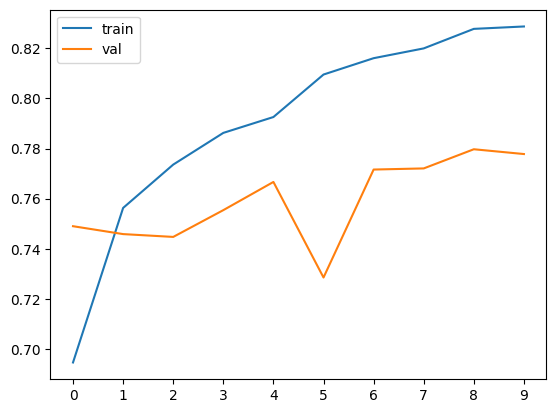

In [108]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [109]:
#Conclusion after training: the model is overfitting

In [110]:
#run prediction for the image used as example
img = load_img(sample_image_fullname, target_size=TARGET_SIZE)
x=np.array(img)
x = preprocess_input(x)
X = np.array([x])
preds = model.predict(X)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float16)

In [111]:
# Get the index of the highest probability
predicted_index = np.argmax(preds, axis=1)[0] 

class_labels = {v: k for k, v in train_gen.class_indices.items()}
predicted_class_name = class_labels[predicted_index]

# Print the result
print(f"The predicted class for the sample image: '{sample_image_displayName}', "
      f"was '{predicted_class_name}' with a probability of: {preds[0][predicted_index]:.4f}")

The predicted class for the sample image: 'Turtle Check Men Navy Blue Shirt', was 'Shirts' with a probability of: 1.0000


### Adjusting learning rate for Model version 1

In [113]:
scores={}
print("Training with different learning rates:\n")
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model_Mobile_v1(learning_rate=lr)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)
    scores[lr]= history.history

    print()
    print()

Training with different learning rates:

0.0001
Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.4170 - loss: 2.6066 - val_accuracy: 0.7240 - val_loss: 0.9923
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.7508 - loss: 0.8599 - val_accuracy: 0.7719 - val_loss: 0.7744
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7971 - loss: 0.6654 - val_accuracy: 0.7934 - val_loss: 0.6927
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8219 - loss: 0.5718 - val_accuracy: 0.8041 - val_loss: 0.6436
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8406 - loss: 0.5026 - val_accuracy: 0.8122 - val_loss: 0.6187
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.8568 - loss: 0.4527 - val_accuracy: 0.8167 - val_loss: 0.5977
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.8687 - loss: 0.4215 - val_accuracy: 0.8213 - val_loss: 0.5808
Epoch 8/10
1112/1112 ━━━━━━━

KeyboardInterrupt: 

In [ ]:
#Plotting the train accuracy
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
#Plotting the validation accuracy
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

In [39]:
#Conclusion: The learning rate 0.001 is the best learning rate
best_learning_rate=0.001

In [40]:
MODELS_DIR = '../models'

In [41]:
#Defining function to delete any previously saved files
def delete_previous_checkpoint_files(filename_pattern):
    regex = re.compile(filename_pattern)
    files = os.listdir(MODELS_DIR)

    matching_files = [f for f in files if regex.match(f)]

    for checkpoint_file in matching_files:
        try:
            os.remove(checkpoint_file)
            print(f"Deleted checkpoint file: {checkpoint_file}")
        except Exception as e:
            print(f"Error deleting file {checkpoint_file}: {e}")

In [42]:
#Define class for a custom checkpoint
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_accuracy = 0.0
        self.best_model_file = ""

    def on_epoch_end(self, epoch, logs=None):
        # Call the parent class's method to save the model if needed
        super().on_epoch_end(epoch, logs)

        # Get the current validation accuracy
        current_val_accuracy = logs.get('val_accuracy')
        
        if current_val_accuracy > self.best_accuracy:
            # Update best values
            self.best_accuracy = current_val_accuracy
            self.best_model_file = self.filepath.format(epoch=epoch + 1, **logs)

In [127]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files("Mobile_v1*.kearas")
print(f'Training the model with learning rate {best_learning_rate}\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v1_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

model = make_model_Mobile_v1(learning_rate=best_learning_rate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)

Deleting files previously saved to output directory

Training the model with learning rate 0.001

Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.6577 - loss: 1.4213 - val_accuracy: 0.8093 - val_loss: 0.6479
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.8559 - loss: 0.4335 - val_accuracy: 0.8153 - val_loss: 0.6142
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.8872 - loss: 0.3287 - val_accuracy: 0.8285 - val_loss: 0.6102
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9080 - loss: 0.2734 - val_accuracy: 0.8334 - val_loss: 0.6001
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.9197 - loss: 0.2368 - val_accuracy: 0.8320 - val_loss: 0.6220
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9270 - loss: 0.2106 - val_accuracy: 0.8338 - val_loss: 0.6290
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9341 - loss: 0.1950 - val_accuracy: 0.83

In [128]:
print(f"Best Validation Accuracy: {round(custom_checkpoint.best_accuracy,4)}")
print(f"Saved Model File: {custom_checkpoint.best_model_file}")

Best Validation Accuracy: 0.8338
Saved Model File: ../models/Mobile_v1_06_0.834.keras


## Create Model version 2 by adding an inner layer

In [43]:
def make_model_Mobile_v2(learning_rate=0.01, inner_layer_units=1420):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu')(vectors)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(inner)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

### Find the best inner layer size

In [45]:
scores={}
for size in [count_classes*3, count_classes*5, count_classes*10, count_classes*20]:
    print(f'Fitting model for size {size}')
    model = make_model_Mobile_v2(learning_rate=best_learning_rate, inner_layer_units=size)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)
    scores[size] = history.history
    print()
    print()

Fitting model for size 710
Epoch 1/10


I0000 00:00:1735358073.830002   82485 service.cc:148] XLA service 0x7fc4dc002040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735358073.830674   82485 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-12-27 22:54:33.927423: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735358074.408327   82485 cuda_dnn.cc:529] Loaded cuDNN version 90600


   6/1112 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.1641 - loss: 4.6134      

I0000 00:00:1735358077.955783   82485 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1112/1112 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.7142 - loss: 1.1130 - val_accuracy: 0.7932 - val_loss: 0.6709
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.8508 - loss: 0.4641 - val_accuracy: 0.8057 - val_loss: 0.6449
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8810 - loss: 0.3354 - val_accuracy: 0.8313 - val_loss: 0.6085
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9056 - loss: 0.2610 - val_accuracy: 0.8226 - val_loss: 0.6905
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9247 - loss: 0.2063 - val_accuracy: 0.8271 - val_loss: 0.6918
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.9398 - loss: 0.1685 - val_accuracy: 0.8281 - val_loss: 0.7211
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9538 - loss: 0.1299 - val_accuracy: 0.8318 - val_loss: 0.7653
Epoch 8/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9606 - loss: 0.11

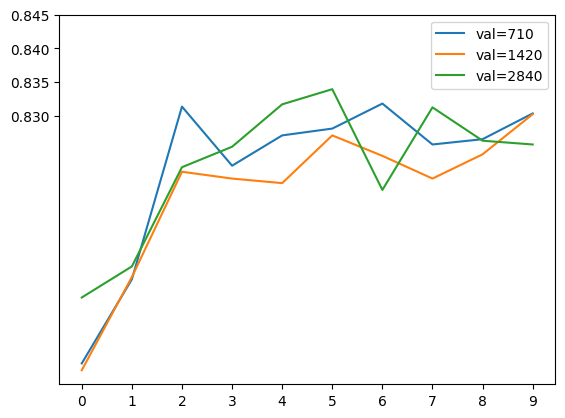

In [48]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
plt.yticks([0.83, 0.835, 0.84, 0.845])
plt.legend()

In [56]:
print('The best accuracy is achieved with an inner layer that has 2840 output units; '
      'however, the precision is not significantly higher compared to the version of the model that doesn\'t include the inner layer.')

The best accuracy is achieved with an inner layer that has 2840 output units; however, the precision is not significantly higher compared to the version of the model that doesn't include the inner layer.
